# M5 Sales Forecasting with Deep Learning

In this notebook, we'll work with the M5 dataset to forecast product sales using various deep learning models.

**Dataset Overview:**
- The M5 dataset contains hierarchical sales data from Walmart
- We'll work with a subset: 10 random products and the first 60 days
- Models to train: LSTM, RNN, GRU, and MLP

**Approach:**
1. Load and explore the data
2. Select 10 random products
3. Filter to first 60 days
4. Prepare data for time series forecasting
5. Train multiple models
6. Compare results

## 1. Import Libraries

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load the Data

In [4]:
# Define data path
data_path = 'm5/'

# Load the datasets
print("Loading datasets...")
sales_train = pd.read_csv(data_path + 'sales_train_validation.csv')
calendar = pd.read_csv(data_path + 'calendar.csv')
sell_prices = pd.read_csv(data_path + 'sell_prices.csv')

print(f"\n✓ Sales data shape: {sales_train.shape}")
print(f"✓ Calendar shape: {calendar.shape}")
print(f"✓ Prices shape: {sell_prices.shape}")

Loading datasets...

✓ Sales data shape: (30490, 1918)
✓ Calendar shape: (1969, 13)
✓ Prices shape: (6841121, 4)

✓ Sales data shape: (30490, 1918)
✓ Calendar shape: (1969, 13)
✓ Prices shape: (6841121, 4)


In [5]:
# Quick look at the sales data
print("Sales data sample:")
sales_train.head()

Sales data sample:


,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
# Calendar structure
print("Calendar sample:")
calendar.head(10)

Calendar sample:


,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,NaN,NaN,NaN,NaN,1,1,0


In [7]:
# Price data structure
print("Price data sample:")
sell_prices.head(10)

Price data sample:


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


## 3. Data Preparation

- Select 10 random products
- Keep only the first 60 days
- Filter calendar and prices accordingly

In [8]:
# Step 1: Select 10 random products
np.random.seed(42)  
all_items = sales_train['item_id'].unique()
selected_items = np.random.choice(all_items, size=10, replace=False)

print(f"Total items in dataset: {len(all_items)}")
print(f"\nSelected 10 random items:")
for i, item in enumerate(selected_items, 1):
    print(f"  {i}. {item}")

Total items in dataset: 3049

Selected 10 random items:
  1. HOUSEHOLD_2_422
  2. FOODS_3_145
  3. FOODS_2_135
  4. HOBBIES_1_352
  5. FOODS_3_439
  6. HOUSEHOLD_2_077
  7. FOODS_3_452
  8. HOUSEHOLD_1_472
  9. FOODS_2_257
  10. HOUSEHOLD_2_349


In [9]:
# Step 2: Filter sales data to selected products
sales_subset = sales_train[sales_train['item_id'].isin(selected_items)].copy()

print(f"Filtered sales data shape: {sales_subset.shape}")
print(f"Number of products: {sales_subset['item_id'].nunique()}")
print(f"Number of stores: {sales_subset['store_id'].nunique()}")

Filtered sales data shape: (100, 1918)
Number of products: 10
Number of stores: 10


In [10]:
# Step 3: Keep only first 60 days
# The columns are: id, item_id, dept_id, cat_id, store_id, state_id, d_1, d_2, ..., d_1913
# We want to keep only d_1 to d_60

day_columns = [f'd_{i}' for i in range(1, 61)]
metadata_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# Check which columns actually exist in sales_subset
available_columns = sales_subset.columns.tolist()
missing_metadata = [col for col in metadata_columns if col not in available_columns]
missing_days = [col for col in day_columns if col not in available_columns]

if missing_metadata:
    print(f" Warning: Missing metadata columns: {missing_metadata}")
    # Remove missing metadata columns
    metadata_columns = [col for col in metadata_columns if col in available_columns]
    
if missing_days:
    print(f" Warning: Missing {len(missing_days)} day columns: {missing_days[:5]}...")
    # Keep only existing day columns
    day_columns = [col for col in day_columns if col in available_columns]

columns_to_keep = metadata_columns + day_columns
sales_60days = sales_subset[columns_to_keep].copy()

print(f"\nSales data with 60 days shape: {sales_60days.shape}")
print(f"Columns: {len(metadata_columns)} metadata + {len(day_columns)} day columns")


Sales data with 60 days shape: (100, 65)
Columns: 5 metadata + 60 day columns


In [11]:
# Step 4: Filter calendar to first 60 days
# Calendar rows correspond to days sequentially (d_1 = row 0, d_2 = row 1, etc.)
calendar_60days = calendar.iloc[:60].copy()

print(f"Calendar filtered shape: {calendar_60days.shape}")
print(f"\nDate range: {calendar_60days['date'].min()} to {calendar_60days['date'].max()}")
print(f"Week range: {calendar_60days['wm_yr_wk'].min()} to {calendar_60days['wm_yr_wk'].max()}")

Calendar filtered shape: (60, 13)

Date range: 2011-01-29 to 2011-03-29
Week range: 11101 to 11109


Date range: 2011-01-29 to 2011-03-29
Week range: 11101 to 11109


In [12]:
# Step 5: Filter prices for the weeks corresponding to first 60 days
weeks_in_60days = calendar_60days['wm_yr_wk'].unique()
prices_60days = sell_prices[
    (sell_prices['wm_yr_wk'].isin(weeks_in_60days)) & 
    (sell_prices['item_id'].isin(selected_items))
].copy()

print(f"Prices filtered shape: {prices_60days.shape}")
print(f"Weeks covered: {sorted(weeks_in_60days)}")
print(f"\nPrice data sample:")
print(prices_60days.head(10))

Prices filtered shape: (490, 4)
Weeks covered: [np.int64(11101), np.int64(11102), np.int64(11103), np.int64(11104), np.int64(11105), np.int64(11106), np.int64(11107), np.int64(11108), np.int64(11109)]

Price data sample:
       store_id          item_id  wm_yr_wk  sell_price
231605     CA_1  HOUSEHOLD_1_472     11101        4.82
231606     CA_1  HOUSEHOLD_1_472     11102        4.82
231607     CA_1  HOUSEHOLD_1_472     11103        4.82
231608     CA_1  HOUSEHOLD_1_472     11104        4.82
231609     CA_1  HOUSEHOLD_1_472     11105        4.82
231610     CA_1  HOUSEHOLD_1_472     11106        4.82
231611     CA_1  HOUSEHOLD_1_472     11107        4.82
231612     CA_1  HOUSEHOLD_1_472     11108        4.82
231613     CA_1  HOUSEHOLD_1_472     11109        4.82
328630     CA_1  HOUSEHOLD_2_349     11101        4.47


## 4. Exploratory Data Analysis


In [13]:
# Create a long-format dataframe for easier analysis
sales_long = sales_60days.melt(
    id_vars=metadata_columns,
    value_vars=day_columns,
    var_name='day',
    value_name='sales'
)

# Extract day number
sales_long['day_num'] = sales_long['day'].str.extract('(\d+)').astype(int)

print(f"Long format shape: {sales_long.shape}")
sales_long.head()

Long format shape: (6000, 8)


,item_id,dept_id,cat_id,store_id,state_id,day,sales,day_num
0,HOBBIES_1_352,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,1
1,HOUSEHOLD_1_472,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_1,0,1
2,HOUSEHOLD_2_077,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,d_1,0,1
3,HOUSEHOLD_2_349,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,d_1,0,1
4,HOUSEHOLD_2_422,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,d_1,0,1


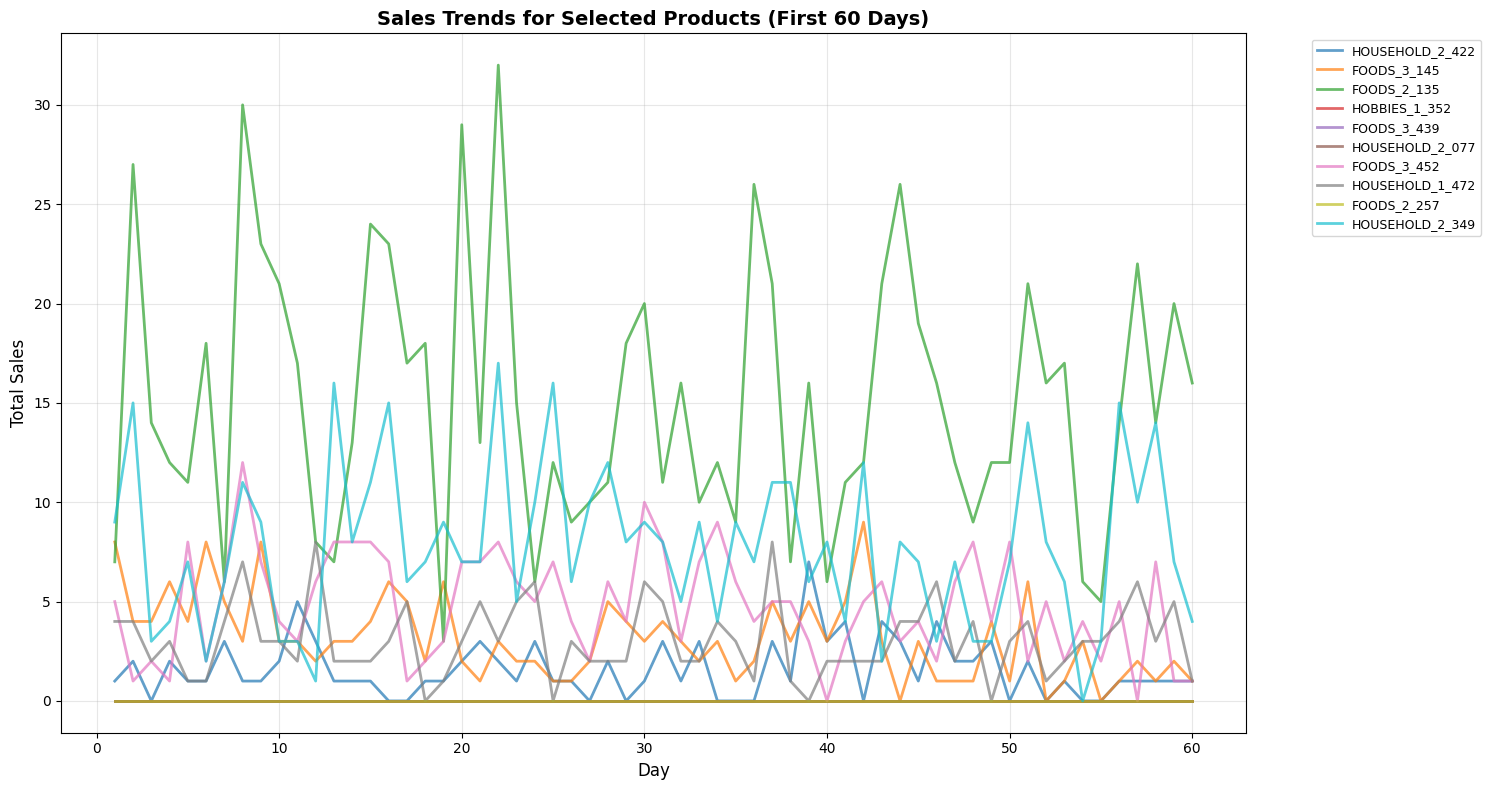

In [14]:
# Plot sales trends for our selected products
plt.figure(figsize=(15, 8))

# Plot each item (aggregated across all stores)
for item in selected_items:
    item_sales = sales_long[sales_long['item_id'] == item].groupby('day_num')['sales'].sum()
    plt.plot(item_sales.index, item_sales.values, label=item, alpha=0.7, linewidth=2)

plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.title('Sales Trends for Selected Products (First 60 Days)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

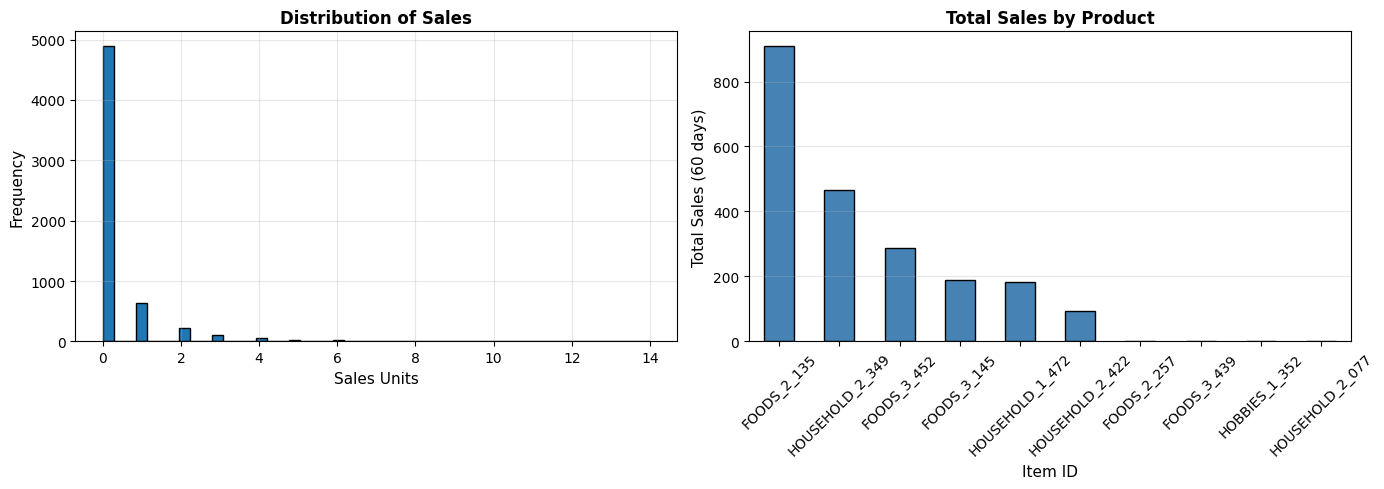


Sales statistics:
count    6000.000000
mean        0.355167
std         0.990212
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        14.000000
Name: sales, dtype: float64


In [15]:
# Sales distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
sales_long['sales'].hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_xlabel('Sales Units', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Sales', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Box plot by item
sales_by_item = sales_long.groupby('item_id')['sales'].sum().sort_values(ascending=False)
sales_by_item.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_xlabel('Item ID', fontsize=11)
axes[1].set_ylabel('Total Sales (60 days)', fontsize=11)
axes[1].set_title('Total Sales by Product', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nSales statistics:")
print(sales_long['sales'].describe())

## 5. Prepare Data for Time Series Forecasting

- Use a sliding window approach
- Input: Last N days of sales
- Output: Next M days of sales
- We'll use lookback=7 days and forecast horizon=3 days

In [16]:
# Parameters for time series preparation
LOOKBACK = 7  # Use last 7 days to predict
FORECAST_HORIZON = 3  # Predict next 3 days
TRAIN_SPLIT = 0.7  # 70% for training
VAL_SPLIT = 0.15   # 15% for validation, 15% for testing

print(f"Time Series Configuration:")
print(f"  Lookback window: {LOOKBACK} days")
print(f"  Forecast horizon: {FORECAST_HORIZON} days")
print(f"  Train/Val/Test split: {TRAIN_SPLIT}/{VAL_SPLIT}/{1-TRAIN_SPLIT-VAL_SPLIT}")

Time Series Configuration:
  Lookback window: 7 days
  Forecast horizon: 3 days
  Train/Val/Test split: 0.7/0.15/0.15000000000000005


In [17]:
def create_sequences(data, lookback, forecast_horizon):
    """
    Create sequences for time series forecasting.
    
    Args:
        data: 1D array of time series data
        lookback: number of past timesteps to use as input
        forecast_horizon: number of future timesteps to predict
    
    Returns:
        X: input sequences
        y: target sequences
    """
    X, y = [], []
    
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback:i + lookback + forecast_horizon])
    
    return np.array(X), np.array(y)

# Test the function
test_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
test_X, test_y = create_sequences(test_data, 3, 2)
print("Example:")
print(f"Input: {test_X[0]} -> Output: {test_y[0]}")
print(f"Input: {test_X[1]} -> Output: {test_y[1]}")

Example:
Input: [1 2 3] -> Output: [4 5]
Input: [2 3 4] -> Output: [5 6]


In [18]:
# Prepare data for all product-store combinations
print("Preparing sequences for all product-store combinations...\n")

all_X = []
all_y = []
scalers = {}  # Store scalers for each series

# Process each unique product-store combination
for idx, row in sales_60days.iterrows():
    # Create a unique series ID from available columns
    series_id = f"{row['item_id']}_{row['store_id']}"
    
    # Extract sales values for 60 days
    sales_values = row[day_columns].values.astype(float)
    
    # Skip if series is too short or all zeros
    if len(sales_values) < (LOOKBACK + FORECAST_HORIZON) or sales_values.sum() == 0:
        continue
    
    # Normalize the data (important for neural networks)
    scaler = MinMaxScaler(feature_range=(0, 1))
    sales_scaled = scaler.fit_transform(sales_values.reshape(-1, 1)).flatten()
    scalers[series_id] = scaler
    
    # Create sequences
    X, y = create_sequences(sales_scaled, LOOKBACK, FORECAST_HORIZON)
    
    all_X.append(X)
    all_y.append(y)

# Combine all sequences
X_all = np.vstack(all_X)
y_all = np.vstack(all_y)

print(f"✓ Total sequences created: {len(X_all)}")
print(f"✓ Input shape: {X_all.shape} (samples, timesteps)")
print(f"✓ Output shape: {y_all.shape} (samples, forecast_horizon)")

Preparing sequences for all product-store combinations...

✓ Total sequences created: 2856
✓ Input shape: (2856, 7) (samples, timesteps)
✓ Output shape: (2856, 3) (samples, forecast_horizon)


In [19]:
# Split into train, validation, and test sets
n_samples = len(X_all)
train_size = int(n_samples * TRAIN_SPLIT)
val_size = int(n_samples * VAL_SPLIT)

X_train = X_all[:train_size]
y_train = y_all[:train_size]

X_val = X_all[train_size:train_size + val_size]
y_val = y_all[train_size:train_size + val_size]

X_test = X_all[train_size + val_size:]
y_test = y_all[train_size + val_size:]

# Reshape for RNN models (samples, timesteps, features)
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_rnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nData splits:")
print(f"  Training: {X_train.shape[0]} samples ({TRAIN_SPLIT*100:.0f}%)")
print(f"  Validation: {X_val.shape[0]} samples ({VAL_SPLIT*100:.0f}%)")
print(f"  Test: {X_test.shape[0]} samples ({(1-TRAIN_SPLIT-VAL_SPLIT)*100:.0f}%)")
print(f"\nRNN input shape: {X_train_rnn.shape}")


Data splits:
  Training: 1999 samples (70%)
  Validation: 428 samples (15%)
  Test: 429 samples (15%)

RNN input shape: (1999, 7, 1)


## 6. Build Deep Learning Models

1. LSTM (Long Short-Term Memory)
2. GRU (Gated Recurrent Unit)
3. Simple RNN
4. MLP (Multi-Layer Perceptron)

In [20]:
# Common training parameters
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10  # For early stopping

print(f"Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Early stopping patience: {PATIENCE}")

Training Configuration:
  Epochs: 50
  Batch size: 32
  Early stopping patience: 10


### 6.1 LSTM Model

In [21]:
print("Building LSTM model...\n")

model_lstm = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model_lstm.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_lstm.summary()

Building LSTM model...



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,891 (116.76 KB)

 Trainable params: 29,891 (116.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Callbacks for LSTM
early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

checkpoint_lstm = ModelCheckpoint(
    'models/lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# Train LSTM
print("Training LSTM...\n")
history_lstm = model_lstm.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_lstm, checkpoint_lstm],
    verbose=1
)

print("\n✓ LSTM training completed!")

Training LSTM...

Epoch 1/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0828 - mae: 0.1732

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0729 - mae: 0.1819 - val_loss: 0.0627 - val_mae: 0.2035
Epoch 2/50
Epoch 2/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0650 - mae: 0.1996

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0643 - mae: 0.1969 - val_loss: 0.0609 - val_mae: 0.1935
Epoch 3/50
Epoch 3/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0645 - mae: 0.1973

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0640 - mae: 0.1956 - val_loss: 0.0607 - val_mae: 0.1921
Epoch 4/50
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0642 - mae: 0.1972

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0639 - mae: 0.1953 - val_loss: 0.0604 - val_mae: 0.1893
Epoch 5/50
Epoch 5/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0639 - mae: 0.1971

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0635 - mae: 0.1952 - val_loss: 0.0603 - val_mae: 0.1893
Epoch 6/50
Epoch 6/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0639 - mae: 0.1965

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0637 - mae: 0.1949 - val_loss: 0.0602 - val_mae: 0.1878
Epoch 7/50
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0636 - mae: 0.1948 - val_loss: 0.0604 - val_mae: 0.1905
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0636 - mae: 0.1948 - val_loss: 0.0604 - val_mae: 0.1905
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0634 - mae: 0.1952 - val_loss: 0.0602 - val_mae: 0.1880
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0634 - mae: 0.1952 - val_loss: 0.0602 - val_mae: 0.1880
Epoch 9/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0636 - mae: 0.1964

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0635 - mae: 0.1944 - val_loss: 0.0599 - val_mae: 0.1857
Epoch 10/50
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0634 - mae: 0.1946 - val_loss: 0.0600 - val_mae: 0.1869
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0634 - mae: 0.1946 - val_loss: 0.0600 - val_mae: 0.1869
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0635 - mae: 0.1942 - val_loss: 0.0602 - val_mae: 0.1879
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0635 - mae: 0.1942 - val_loss: 0.0602 - val_mae: 0.1879
Epoch 12/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0638 - mae: 0.1966

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0634 - mae: 0.1944 - val_loss: 0.0599 - val_mae: 0.1851
Epoch 13/50
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1947 - val_loss: 0.0600 - val_mae: 0.1863
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1947 - val_loss: 0.0600 - val_mae: 0.1863
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1944 - val_loss: 0.0600 - val_mae: 0.1867
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1944 - val_loss: 0.0600 - val_mae: 0.1867
Epoch 15/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0633 - mae: 0.1956

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0629 - mae: 0.1933 - val_loss: 0.0598 - val_mae: 0.1838
Epoch 16/50
Epoch 16/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0631 - mae: 0.1936 - val_loss: 0.0599 - val_mae: 0.1848
Epoch 17/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0631 - mae: 0.1936 - val_loss: 0.0599 - val_mae: 0.1848
Epoch 17/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0630 - mae: 0.1935 - val_loss: 0.0598 - val_mae: 0.1839
Epoch 18/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0630 - mae: 0.1935 - val_loss: 0.0598 - val_mae: 0.1839
Epoch 18/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0631 - mae: 0.1935 - val_loss: 0.0599 - val_mae: 0.1851
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0631 - mae: 0.1935 - val_loss: 0.0599 - val_mae: 0.1851
Epoch 19/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0633 - mae: 0.1950

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0629 - mae: 0.1933 - val_loss: 0.0597 - val_mae: 0.1829
Epoch 20/50
Epoch 20/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0630 - mae: 0.1928 - val_loss: 0.0598 - val_mae: 0.1842
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0630 - mae: 0.1928 - val_loss: 0.0598 - val_mae: 0.1842
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0628 - mae: 0.1928 - val_loss: 0.0599 - val_mae: 0.1853
Epoch 22/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0628 - mae: 0.1928 - val_loss: 0.0599 - val_mae: 0.1853
Epoch 22/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0630 - mae: 0.1932 - val_loss: 0.0599 - val_mae: 0.1848
Epoch 23/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0630 - mae: 0.1932 - val_loss: 0.0599 - val_mae: 0.1848
Epoch 23/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0629 - mae: 0.1929 - val_loss: 0.0598 - val_mae: 0.1841
Epoch 24/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.062

### 6.2 GRU Model

In [23]:
print("Building GRU model...\n")

model_gru = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),
    GRU(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model_gru.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_gru.summary()

Building GRU model...



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 64)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,851 (89.26 KB)

 Trainable params: 22,851 (89.26 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Callbacks for GRU
early_stop_gru = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

checkpoint_gru = ModelCheckpoint(
    'models/gru_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# Train GRU
print("Training GRU...\n")
history_gru = model_gru.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_gru, checkpoint_gru],
    verbose=1
)

print("\n✓ GRU training completed!")

Training GRU...

Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0819 - mae: 0.1737

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0728 - mae: 0.1821 - val_loss: 0.0617 - val_mae: 0.1919
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0654 - mae: 0.1979

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0647 - mae: 0.1967 - val_loss: 0.0606 - val_mae: 0.1890
Epoch 3/50
Epoch 3/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0646 - mae: 0.1982

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0640 - mae: 0.1963 - val_loss: 0.0601 - val_mae: 0.1865
Epoch 4/50
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0647 - mae: 0.1979

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0642 - mae: 0.1959 - val_loss: 0.0598 - val_mae: 0.1833
Epoch 5/50
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0641 - mae: 0.1952 - val_loss: 0.0598 - val_mae: 0.1836
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0641 - mae: 0.1952 - val_loss: 0.0598 - val_mae: 0.1836
Epoch 6/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0645 - mae: 0.1971

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0639 - mae: 0.1952 - val_loss: 0.0597 - val_mae: 0.1827
Epoch 7/50
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0635 - mae: 0.1940 - val_loss: 0.0597 - val_mae: 0.1826
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0635 - mae: 0.1940 - val_loss: 0.0597 - val_mae: 0.1826
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0635 - mae: 0.1943 - val_loss: 0.0597 - val_mae: 0.1821
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0635 - mae: 0.1943 - val_loss: 0.0597 - val_mae: 0.1821
Epoch 9/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0637 - mae: 0.1957

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0634 - mae: 0.1938 - val_loss: 0.0596 - val_mae: 0.1802
Epoch 10/50
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1941 - val_loss: 0.0597 - val_mae: 0.1814
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1941 - val_loss: 0.0597 - val_mae: 0.1814
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1938 - val_loss: 0.0597 - val_mae: 0.1807
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1938 - val_loss: 0.0597 - val_mae: 0.1807
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0634 - mae: 0.1940 - val_loss: 0.0597 - val_mae: 0.1804
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0634 - mae: 0.1940 - val_loss: 0.0597 - val_mae: 0.1804
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0633 - mae: 0.1937 - val_loss: 0.0597 - val_mae: 0.1801
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.063

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0631 - mae: 0.1928 - val_loss: 0.0596 - val_mae: 0.1783
Epoch 18/50
Epoch 18/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0631 - mae: 0.1931 - val_loss: 0.0597 - val_mae: 0.1816
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0631 - mae: 0.1931 - val_loss: 0.0597 - val_mae: 0.1816
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0630 - mae: 0.1930 - val_loss: 0.0597 - val_mae: 0.1806
Epoch 20/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0630 - mae: 0.1930 - val_loss: 0.0597 - val_mae: 0.1806
Epoch 20/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0628 - mae: 0.1921 - val_loss: 0.0597 - val_mae: 0.1804
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0628 - mae: 0.1921 - val_loss: 0.0597 - val_mae: 0.1804
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0629 - mae: 0.1930 - val_loss: 0.0598 - val_mae: 0.1828
Epoch 22/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.06

### 6.3 Simple RNN Model

In [25]:
print("Building Simple RNN model...\n")

model_rnn = Sequential([
    SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model_rnn.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_rnn.summary()

Building Simple RNN model...



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 7, 64)          │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,907 (30.89 KB)

 Trainable params: 7,907 (30.89 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Callbacks for RNN
early_stop_rnn = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

checkpoint_rnn = ModelCheckpoint(
    'models/rnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# Train RNN
print("Training Simple RNN...\n")
history_rnn = model_rnn.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_rnn, checkpoint_rnn],
    verbose=1
)

print("\n✓ Simple RNN training completed!")

Training Simple RNN...

Epoch 1/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0861 - mae: 0.1947

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0728 - mae: 0.1921 - val_loss: 0.0603 - val_mae: 0.1855
Epoch 2/50
Epoch 2/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0649 - mae: 0.1960

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0646 - mae: 0.1947 - val_loss: 0.0602 - val_mae: 0.1844
Epoch 3/50
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0641 - mae: 0.1944 - val_loss: 0.0602 - val_mae: 0.1848
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0641 - mae: 0.1944 - val_loss: 0.0602 - val_mae: 0.1848
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0643 - mae: 0.1947 - val_loss: 0.0603 - val_mae: 0.1855
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0643 - mae: 0.1947 - val_loss: 0.0603 - val_mae: 0.1855
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 - mae: 0.1959

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0637 - mae: 0.1951 - val_loss: 0.0601 - val_mae: 0.1850
Epoch 6/50
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0637 - mae: 0.1944 - val_loss: 0.0601 - val_mae: 0.1846
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0637 - mae: 0.1944 - val_loss: 0.0601 - val_mae: 0.1846
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0634 - mae: 0.1936 - val_loss: 0.0601 - val_mae: 0.1847
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0634 - mae: 0.1936 - val_loss: 0.0601 - val_mae: 0.1847
Epoch 8/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0637 - mae: 0.1951

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0634 - mae: 0.1941 - val_loss: 0.0600 - val_mae: 0.1843
Epoch 9/50
Epoch 9/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0630 - mae: 0.1943

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0628 - mae: 0.1927 - val_loss: 0.0600 - val_mae: 0.1840
Epoch 10/50
Epoch 10/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0630 - mae: 0.1942

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0630 - mae: 0.1926 - val_loss: 0.0598 - val_mae: 0.1819
Epoch 11/50
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0628 - mae: 0.1925 - val_loss: 0.0600 - val_mae: 0.1843
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0628 - mae: 0.1925 - val_loss: 0.0600 - val_mae: 0.1843
Epoch 12/50
50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0627 - mae: 0.1934

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0626 - mae: 0.1914 - val_loss: 0.0598 - val_mae: 0.1815
Epoch 13/50
Epoch 13/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0624 - mae: 0.1935

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0624 - mae: 0.1915 - val_loss: 0.0597 - val_mae: 0.1801
Epoch 14/50
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0625 - mae: 0.1921 - val_loss: 0.0598 - val_mae: 0.1803
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0625 - mae: 0.1921 - val_loss: 0.0598 - val_mae: 0.1803
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0624 - mae: 0.1917 - val_loss: 0.0599 - val_mae: 0.1809
Epoch 16/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0624 - mae: 0.1917 - val_loss: 0.0599 - val_mae: 0.1809
Epoch 16/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0626 - mae: 0.1907 - val_loss: 0.0600 - val_mae: 0.1821
Epoch 17/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0626 - mae: 0.1907 - val_loss: 0.0600 - val_mae: 0.1821
Epoch 17/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0621 - mae: 0.1906 - val_loss: 0.0599 - val_mae: 0.1806
Epoch 18/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.062

### 6.4 MLP Model

In [27]:
print("Building MLP model...\n")

model_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(LOOKBACK,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model_mlp.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_mlp.summary()

Building MLP model...



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,939 (46.64 KB)

 Trainable params: 11,939 (46.64 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Callbacks for MLP
early_stop_mlp = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

checkpoint_mlp = ModelCheckpoint(
    'models/mlp_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# Train MLP (uses flattened input, not 3D)
print("Training MLP...\n")
history_mlp = model_mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_mlp, checkpoint_mlp],
    verbose=1
)

print("\n✓ MLP training completed!")

Training MLP...

Epoch 1/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0886 - mae: 0.1932

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0736 - mae: 0.1899 - val_loss: 0.0610 - val_mae: 0.1853
Epoch 2/50
Epoch 2/50
48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0654 - mae: 0.1967

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0649 - mae: 0.1945 - val_loss: 0.0608 - val_mae: 0.1862
Epoch 3/50
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0646 - mae: 0.1963

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0640 - mae: 0.1949 - val_loss: 0.0605 - val_mae: 0.1838
Epoch 4/50
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0639 - mae: 0.1948

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0636 - mae: 0.1939 - val_loss: 0.0604 - val_mae: 0.1874
Epoch 5/50
Epoch 5/50
54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0636 - mae: 0.1956

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0635 - mae: 0.1939 - val_loss: 0.0602 - val_mae: 0.1840
Epoch 6/50
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0637 - mae: 0.1937 - val_loss: 0.0604 - val_mae: 0.1868
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0637 - mae: 0.1937 - val_loss: 0.0604 - val_mae: 0.1868
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0638 - mae: 0.1952 - val_loss: 0.0605 - val_mae: 0.1877
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0638 - mae: 0.1952 - val_loss: 0.0605 - val_mae: 0.1877
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 - mae: 0.1950 - val_loss: 0.0608 - val_mae: 0.1880
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 - mae: 0.1950 - val_loss: 0.0608 - val_mae: 0.1880
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0633 - mae: 0.1947 - val_loss: 0.0606 - val_mae: 0.1869
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0633 - mae:

## 7. Visualize Training History

Let's see how each model learned during training.

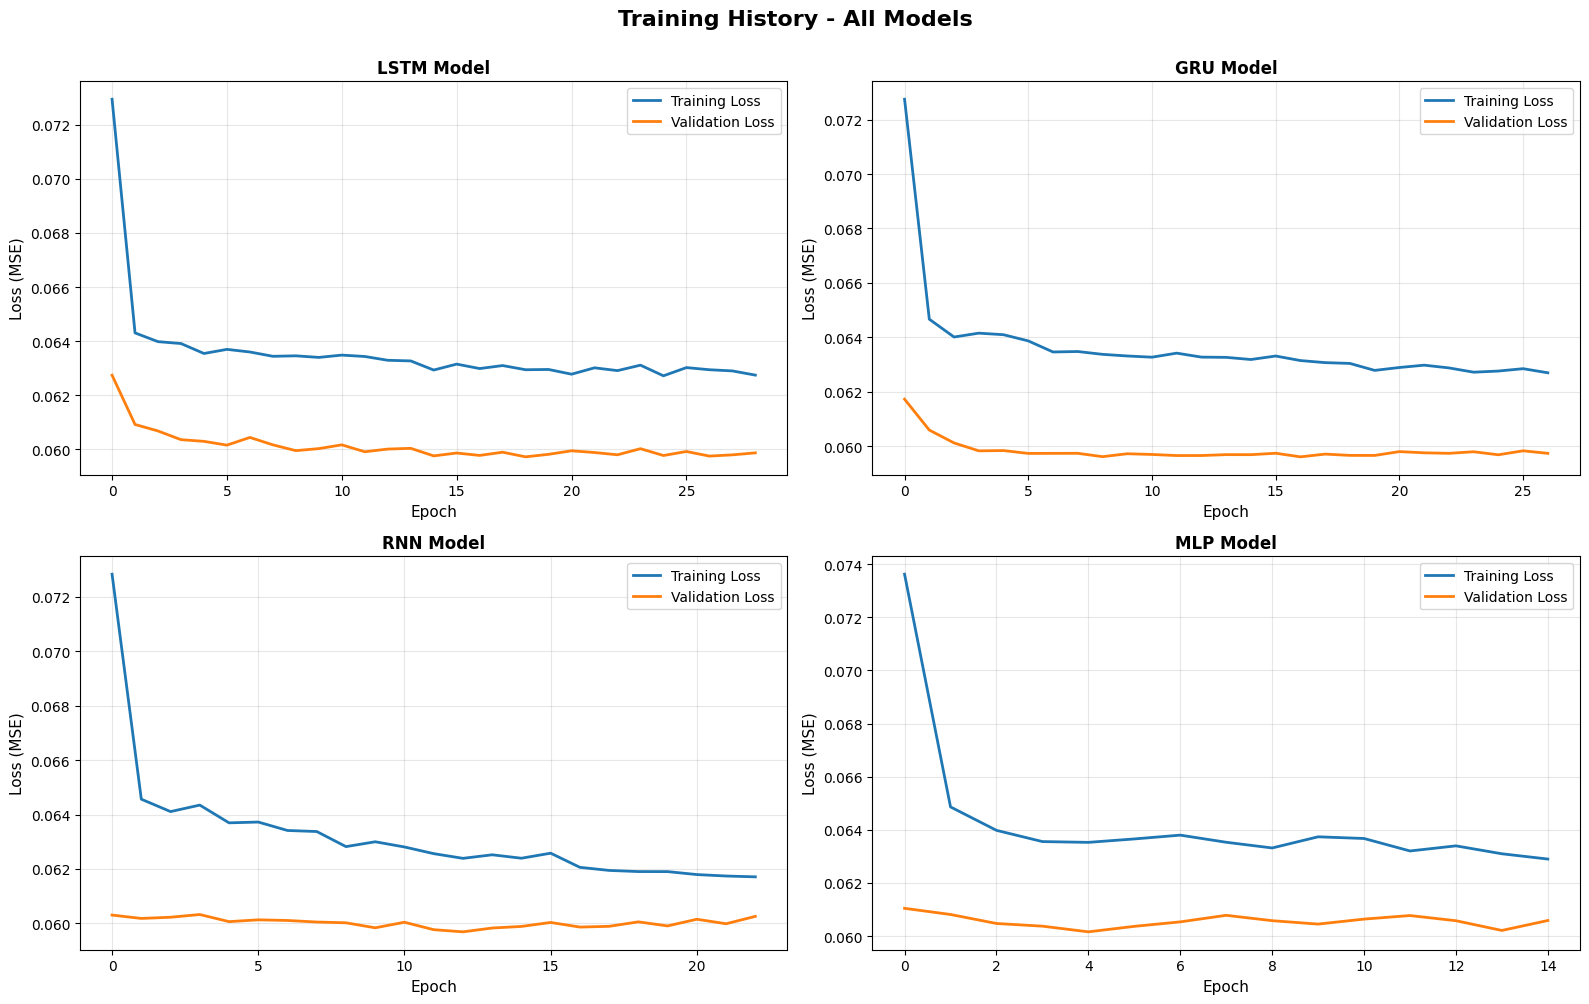

In [29]:
# Plot training history for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Training History - All Models', fontsize=16, fontweight='bold', y=1.00)

models_history = [
    ('LSTM', history_lstm),
    ('GRU', history_gru),
    ('RNN', history_rnn),
    ('MLP', history_mlp)
]

for idx, (name, history) in enumerate(models_history):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Plot loss
    ax.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss (MSE)', fontsize=11)
    ax.set_title(f'{name} Model', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Model Evaluation

Now let's evaluate all models on the test set.

In [30]:
# Make predictions on test set
print("Making predictions on test set...\n")

predictions = {
    'LSTM': model_lstm.predict(X_test_rnn, verbose=0),
    'GRU': model_gru.predict(X_test_rnn, verbose=0),
    'RNN': model_rnn.predict(X_test_rnn, verbose=0),
    'MLP': model_mlp.predict(X_test, verbose=0)
}

print("✓ Predictions completed for all models")

Making predictions on test set...

✓ Predictions completed for all models
✓ Predictions completed for all models


In [31]:
# Calculate metrics for each model
results = []

for model_name, y_pred in predictions.items():
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    # Only calculate MAPE for non-zero actual values to avoid division issues
    mask = y_test > 0.01  # Filter out very small/zero values
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    else:
        mape = np.nan
    
    results.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape
    })

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('RMSE')

print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


MODEL EVALUATION RESULTS
Model     RMSE      MAE  MAPE (%)
  RNN 0.242581 0.178170 60.621990
 LSTM 0.243230 0.182110 60.799562
  GRU 0.243831 0.179216 61.593370
  MLP 0.246341 0.184676 61.306679


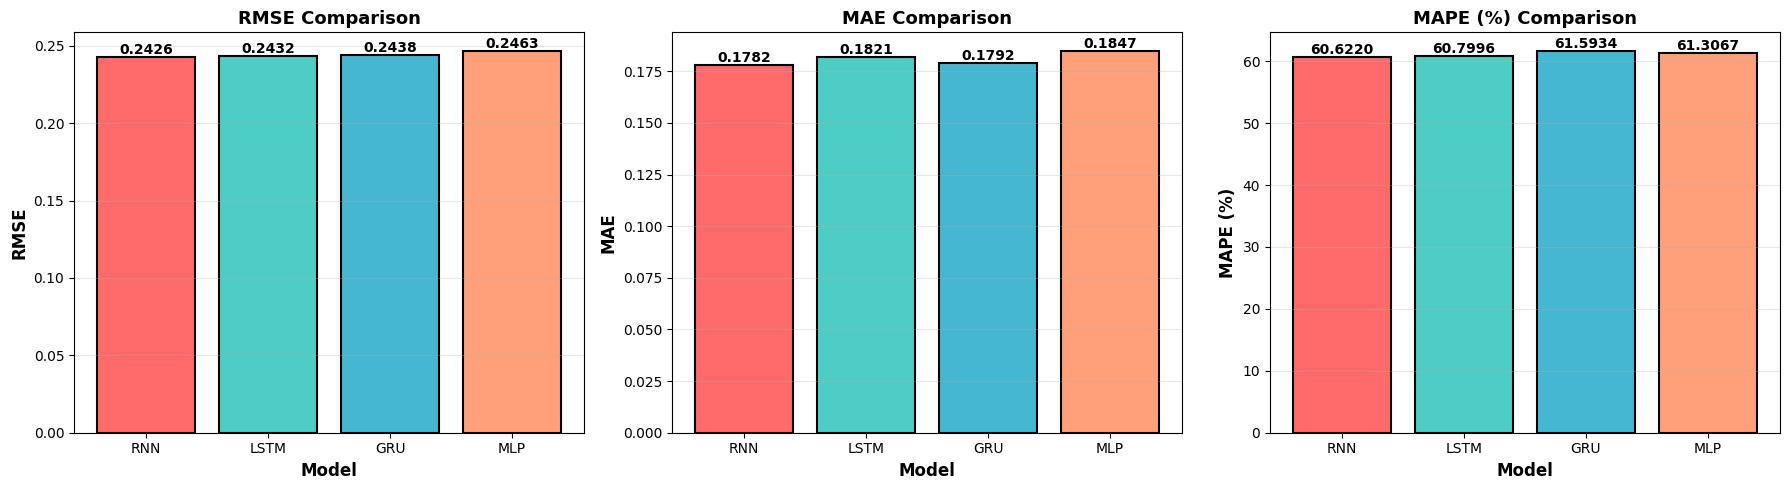


 Best model (lowest RMSE): RNN


In [32]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['RMSE', 'MAE', 'MAPE (%)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Best model (lowest RMSE): {results_df.iloc[0]['Model']}")

## 9. Visualize Predictions

Let's visualize some sample predictions from each model.

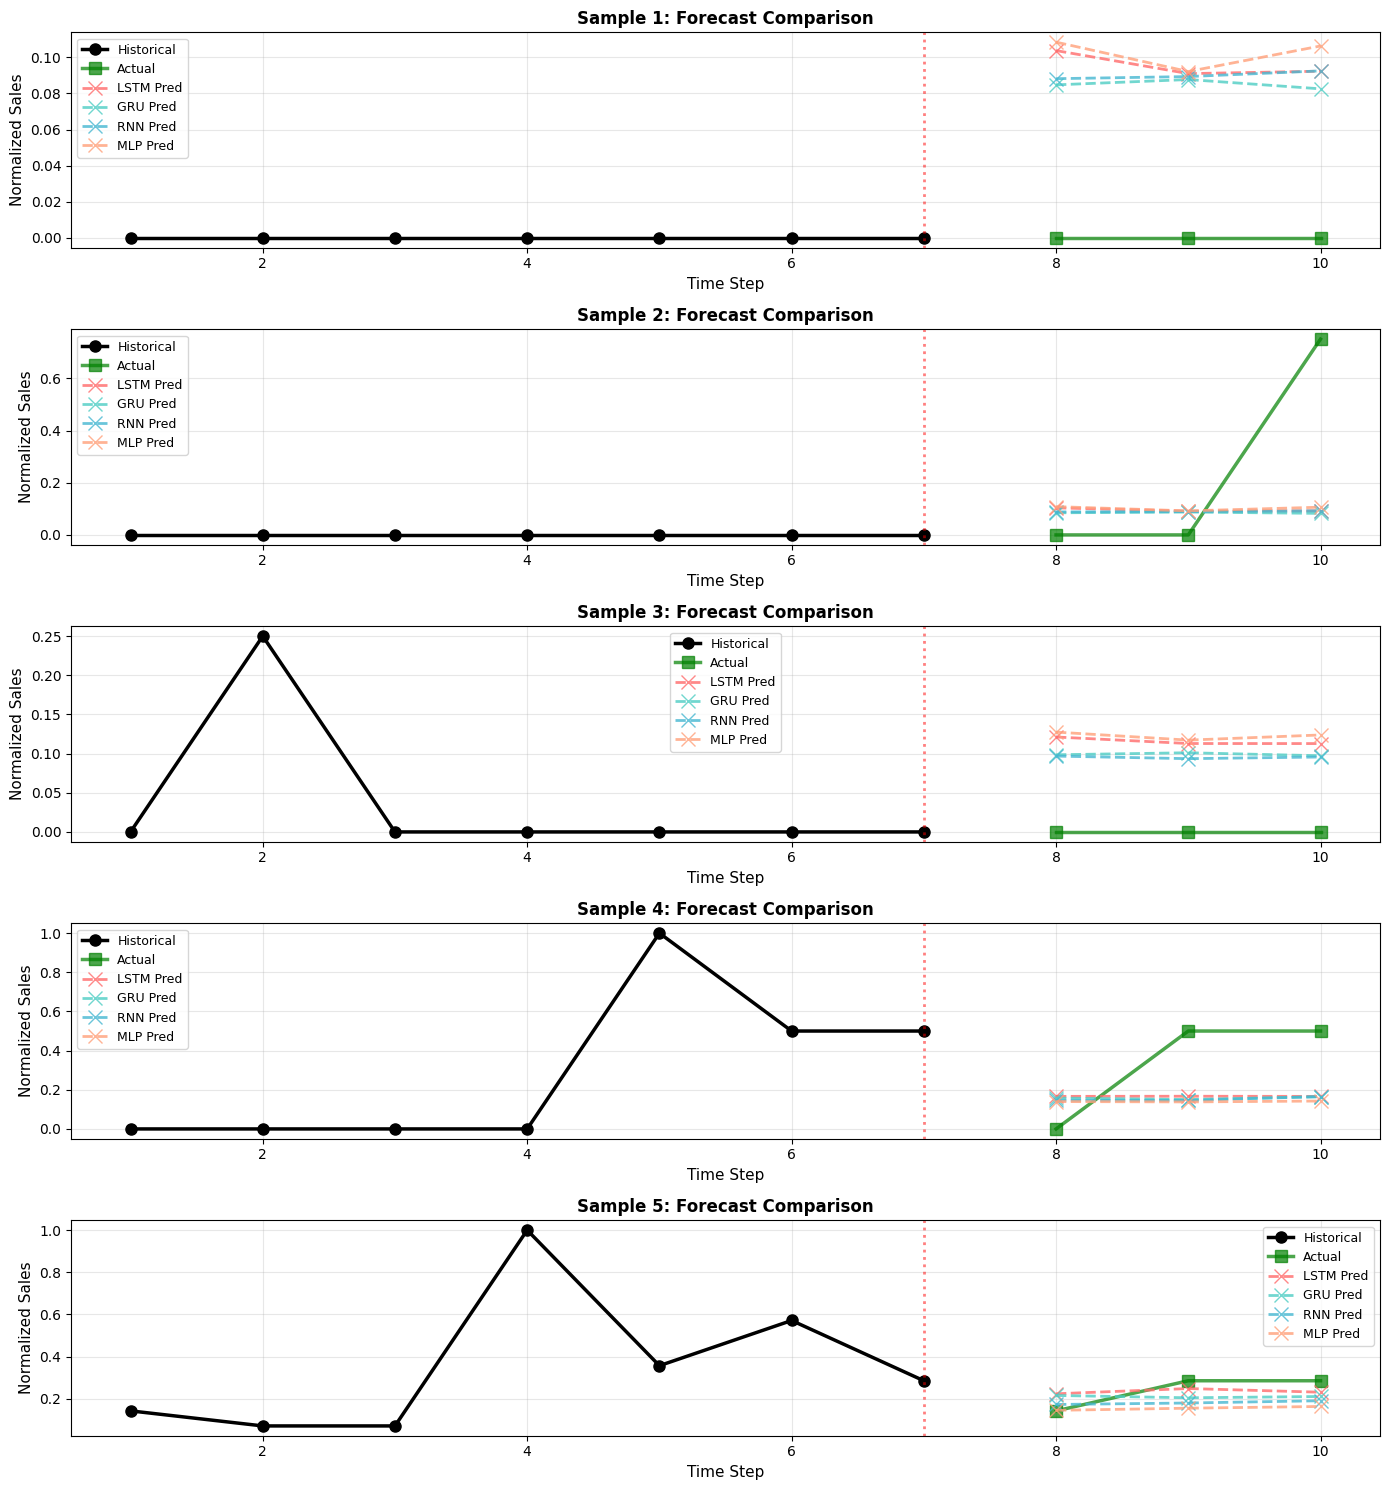

In [33]:
# Select a few random samples to visualize
n_samples_to_show = 5
sample_indices = np.random.choice(len(X_test), n_samples_to_show, replace=False)

fig, axes = plt.subplots(n_samples_to_show, 1, figsize=(14, 3*n_samples_to_show))
if n_samples_to_show == 1:
    axes = [axes]

for i, idx in enumerate(sample_indices):
    ax = axes[i]
    
    # Historical data (input)
    history = X_test[idx]
    actual = y_test[idx]
    
    # Time axis
    history_time = range(1, LOOKBACK + 1)
    future_time = range(LOOKBACK + 1, LOOKBACK + 1 + FORECAST_HORIZON)
    
    # Plot historical data
    ax.plot(history_time, history, 'o-', label='Historical', 
            linewidth=2.5, markersize=8, color='black')
    
    # Plot actual future values
    ax.plot(future_time, actual, 's-', label='Actual', 
            linewidth=2.5, markersize=8, color='green', alpha=0.7)
    
    # Plot predictions from each model
    for model_name, color in zip(['LSTM', 'GRU', 'RNN', 'MLP'], colors):
        pred = predictions[model_name][idx]
        ax.plot(future_time, pred, 'x--', label=f'{model_name} Pred', 
                linewidth=2, markersize=10, color=color, alpha=0.8)
    
    ax.set_xlabel('Time Step', fontsize=11)
    ax.set_ylabel('Normalized Sales', fontsize=11)
    ax.set_title(f'Sample {i+1}: Forecast Comparison', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=LOOKBACK, color='red', linestyle=':', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.show()

## 10. Error Analysis

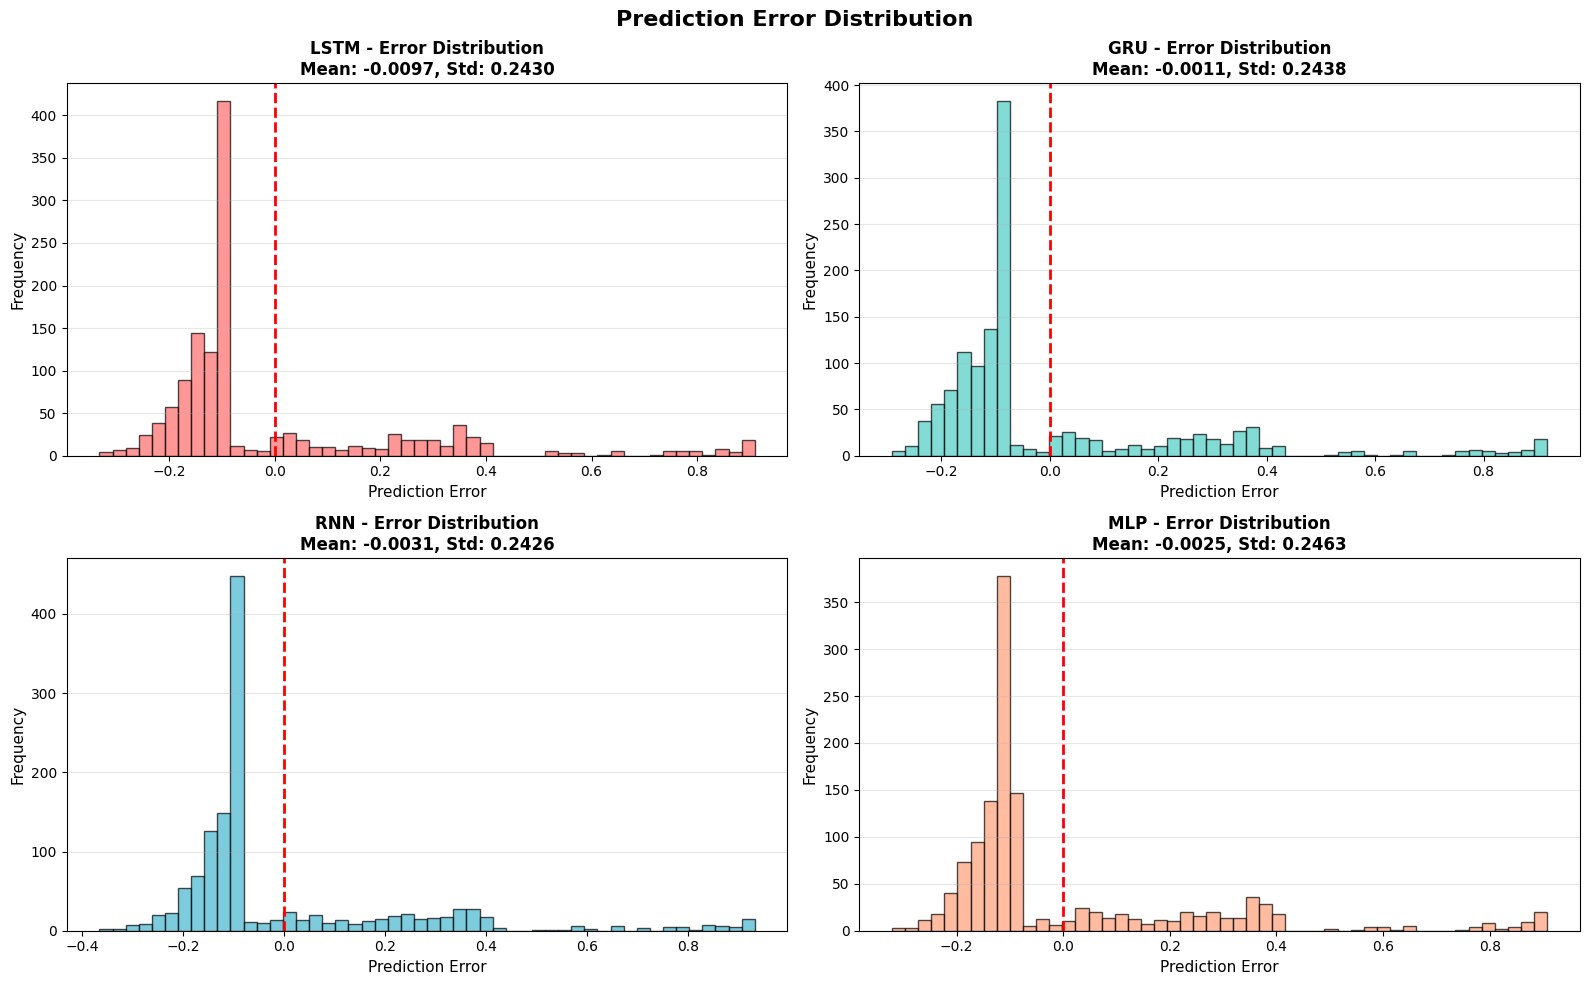

In [34]:
# Calculate prediction errors for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Prediction Error Distribution', fontsize=16, fontweight='bold')

for idx, (model_name, color) in enumerate(zip(['LSTM', 'GRU', 'RNN', 'MLP'], colors)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Calculate errors
    errors = y_test - predictions[model_name]
    errors_flat = errors.flatten()
    
    # Plot histogram
    ax.hist(errors_flat, bins=50, color=color, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Prediction Error', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{model_name} - Error Distribution\nMean: {errors_flat.mean():.4f}, Std: {errors_flat.std():.4f}', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Save Models and Results

In [35]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save all models (they're already saved via callbacks, but let's be explicit)
print("Saving trained models...\n")

model_lstm.save('models/lstm_model_final.h5')
model_gru.save('models/gru_model_final.h5')
model_rnn.save('models/rnn_model_final.h5')
model_mlp.save('models/mlp_model_final.h5')

print("✓ LSTM model saved to: models/lstm_model_final.h5")
print("✓ GRU model saved to: models/gru_model_final.h5")
print("✓ RNN model saved to: models/rnn_model_final.h5")
print("✓ MLP model saved to: models/mlp_model_final.h5")

Saving trained models...

✓ LSTM model saved to: models/lstm_model_final.h5
✓ GRU model saved to: models/gru_model_final.h5
✓ RNN model saved to: models/rnn_model_final.h5
✓ MLP model saved to: models/mlp_model_final.h5


In [36]:
# Save results to CSV
results_df.to_csv('models/model_comparison_results.csv', index=False)
print("\n✓ Results saved to: models/model_comparison_results.csv")

# Save selected products list
pd.DataFrame({'item_id': selected_items}).to_csv('models/selected_products.csv', index=False)
print("✓ Selected products saved to: models/selected_products.csv")


✓ Results saved to: models/model_comparison_results.csv
✓ Selected products saved to: models/selected_products.csv


In [37]:
# Save configuration
config = {
    'lookback': LOOKBACK,
    'forecast_horizon': FORECAST_HORIZON,
    'train_split': TRAIN_SPLIT,
    'val_split': VAL_SPLIT,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'num_products': len(selected_items),
    'num_days': 60,
    'total_sequences': len(X_all),
    'best_model': results_df.iloc[0]['Model'],
    'best_rmse': results_df.iloc[0]['RMSE']
}

import json
with open('models/config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("✓ Configuration saved to: models/config.json")

✓ Configuration saved to: models/config.json
